In [1]:
import re
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UGate
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
import numpy as np


In [ ]:
# Define the oracle dynamically for the marked state
def create_oracle(marked_state):
    n = len(marked_state)
    oracle = QuantumCircuit(n, name='oracle')
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
    oracle.h(n - 1)
    oracle.mcx(list(range(n - 1)), n - 1)
    oracle.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
    return oracle.to_gate()

In [ ]:
# Define the Grover reflection operator
def create_reflection(n):
    reflection = QuantumCircuit(n, name='reflection')
    reflection.h(range(n))
    reflection.x(range(n))
    reflection.h(n - 1)
    reflection.mcx(list(range(n - 1)), n - 1)
    reflection.h(n - 1)
    reflection.x(range(n))
    reflection.h(range(n))
    return reflection.to_gate()

In [ ]:
# Define the Grover's circuit with a specific marked state
def grover_circuit(marked_state):
    """
    Creates the full Grover circuit for a given marked state.
    """
    n = len(marked_state)  # Number of qubits required
    grover_circ = QuantumCircuit(n, n)  # Classical bits = qubits for measurement
    grover_circ.h(range(n))  # Apply Hadamard gates to all qubits

    # Add the oracle and reflection gates
    oracle_gate = create_oracle(marked_state)
    reflection_gate = create_reflection(n)

    # Repeat Grover iterations
    num_iterations = int(np.round(np.sqrt(2 ** n)))  # Optimal number of iterations
    for _ in range(num_iterations):
        grover_circ.append(oracle_gate, range(n))
        grover_circ.append(reflection_gate, range(n))

    # Measure all qubits
    grover_circ.measure(range(n), range(n))
    return grover_circ

In [ ]:
# Test Grover's circuit with a specific marked state
marked_state = '010'  # Specify the marked state
grover_circ = grover_circuit(marked_state)
grover_circ.draw('mpl')

In [ ]:
# Simulate the Grover circuit
simulator = QasmSimulator()
compiled_circuit = transpile(grover_circ, simulator)
result = simulator.run(compiled_circuit, shots=512).result()

In [ ]:
# Get the measurement counts (bitstring outcomes)
counts = result.get_counts()
corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
print(corrected_counts)

# Plot the results
display(plot_histogram(corrected_counts))

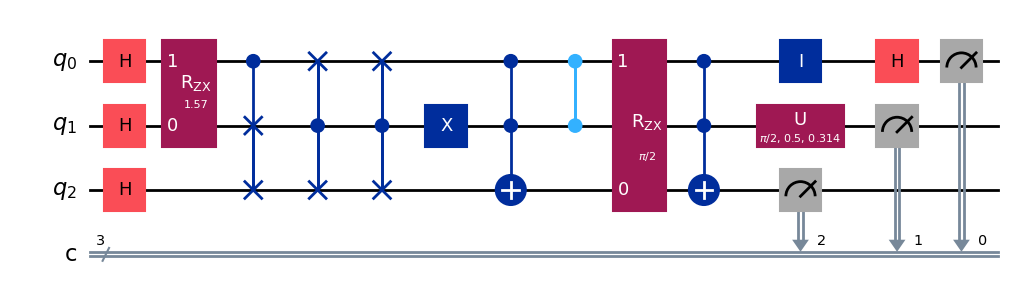

In [ ]:
# def fitness_function(
#     circuit, 
#     marked_state='010', 
#     shots=512,
#     zero_prob_penalty=20.0,
#     gate_penalty_weight=0.01
# ):
#     """
#     Evaluates a Grover-like circuit, ensuring every basis state appears with 
#     nonzero probability, and penalizing circuits that contain too many gates.

#     1) Base fitness = (1 - p_marked):
#        - Lower is better. If the circuit always measures `marked_state`, 
#          this part is 0.0.

#     2) If *any* state has zero counts, add a fixed penalty (zero_prob_penalty).

#     3) Gate-count penalty = gate_penalty_weight * circuit_size
#        - Encourages fewer gates.

#     Args:
#         circuit (QuantumCircuit): Circuit that includes oracle/diffuser/measure.
#         marked_state (str): The target bitstring, e.g., '010' in q0q1q2 order.
#         shots (int): Number of shots for QasmSimulator.
#         zero_prob_penalty (float): The fixed penalty if any state has prob=0.
#         gate_penalty_weight (float): Scales how heavily gate count is penalized.

#     Returns:
#         float: A fitness score (lower is better).
#     """
#     # 1) Simulate the circuit
#     simulator = QasmSimulator()
#     # Transpile with a low optimization level, so we accurately see the raw gate count
#     compiled_circuit = transpile(circuit, simulator, optimization_level=0)
#     result = simulator.run(compiled_circuit, shots=shots).result()
#     counts = result.get_counts()

#     # 2) Reverse bitstrings so '010' matches qubit order q0q1q2
#     corrected_counts = {k[::-1]: v for k, v in counts.items()}
#     total_shots = sum(corrected_counts.values())

#     # 3) Probability of the marked state
#     marked_count = corrected_counts.get(marked_state, 0)
#     p_marked = marked_count / total_shots if total_shots > 0 else 0.0
#     base_fitness = 1.0 - p_marked  # 0.0 is best if p_marked = 1.0

#     # 4) Check for zero-prob states
#     num_qubits = circuit.num_qubits
#     all_states = [format(i, '0{}b'.format(num_qubits)) for i in range(2**num_qubits)]
#     distribution = {}
#     for state in all_states:
#         distribution[state] = corrected_counts.get(state, 0) / total_shots
#     zero_prob_states = sum(1 for s in all_states if distribution[s] == 0.0)

#     # 5) Penalty if ANY state is zero-prob
#     zero_prob_penalty_term = zero_prob_penalty if zero_prob_states > 0 else 0.0

#     # 6) Gate-count penalty
#     circuit_size = compiled_circuit.size()  # total number of gates
#     gate_penalty = gate_penalty_weight * circuit_size

#     # 7) Final fitness (lower = better)
#     final_fitness = base_fitness + zero_prob_penalty_term + gate_penalty
#     return final_fitness


Final Measurement Counts: {'101': 14, '011': 2, '001': 290, '100': 82, '000': 92, '010': 7, '111': 16, '110': 9}


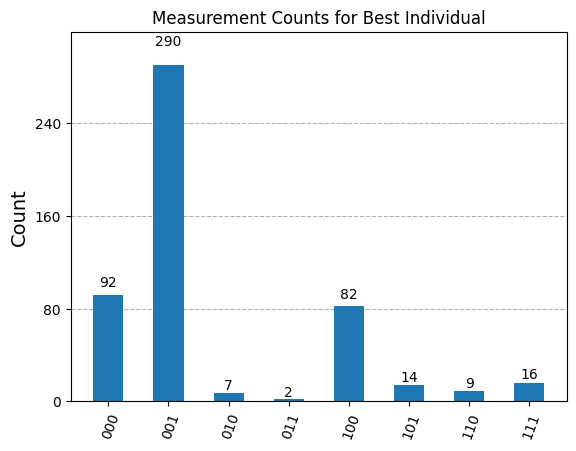

In [3]:
simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=512).result()
counts = result.get_counts()
corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
print("\nFinal Measurement Counts:", corrected_counts)
display(plot_histogram(corrected_counts, title="Measurement Counts for Best Individual"))

In [12]:
phenotype_str = (
    "qc = QuantumCircuit(3, 3)\n"
    "qc.h(0)\n"
    "qc.h(1)\n"
    "qc.h(2)\n"
    "## Begin Oracle\n"
    "qc.cswap(2,1,0)\n"
    "qc.rzz(2*np.pi,2,0)\n"
    "## End Oracle\n"
    "## Begin Diffuser\n"
    "qc.x(2)\n"
    "qc.cx(0,2)\n"
    "## End Diffuser\n"
    "qc.measure(0, 0)\n"
    "qc.measure(1, 1)\n"
    "qc.measure(2, 2)\n"
)

In [14]:
def generate_oracle_code(marked_state):
    n = len(marked_state)
    code_lines = []
    # For each qubit, if the bit is '0', apply an X gate.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Apply the Grover oracle's core operations.
    code_lines.append(f"qc.h({n-1})")
    # Use a multi-controlled X gate (or equivalent) as in your oracle.
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    # Undo the X gates.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Join the lines into a single code block.
    return "\n".join(code_lines) + "\n"

In [15]:
import re

def replace_oracle_block(phenotype_str, new_oracle_code):
    # The pattern matches the text between "## Begin Oracle" and "## End Oracle"
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + new_oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

# Example: Replace oracle for a specific marked state, e.g. '010'
marked_state = '111'
new_oracle = generate_oracle_code(marked_state)
modified_phenotype = replace_oracle_block(phenotype_str, new_oracle)

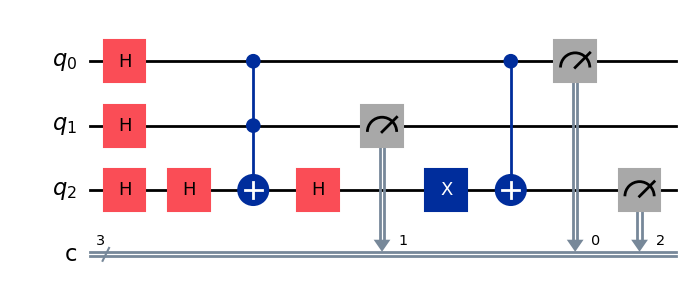


Final Measurement Counts: {'100': 56, '110': 65, '001': 58, '010': 58, '000': 65, '101': 70, '111': 69, '011': 71}


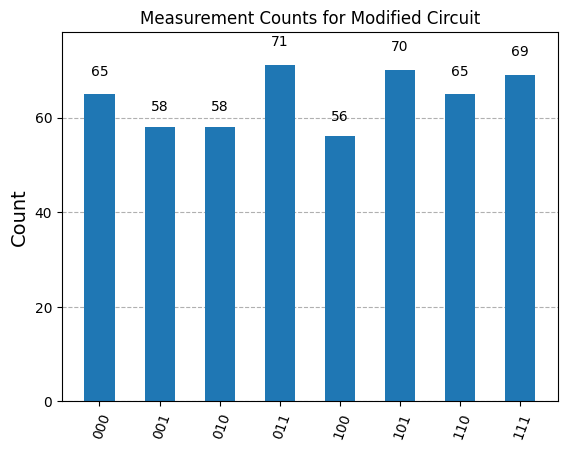

In [16]:
# Assuming modified_phenotype has been created as in your previous cell
# Create a dictionary to capture the local variables defined by exec.
local_vars = {}
exec(modified_phenotype, globals(), local_vars)

# Now check if the variable 'qc' was created.
if "qc" in local_vars:
    circuit = local_vars["qc"]
    
    # Display the circuit diagram
    display(circuit.draw("mpl"))
    

    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=512).result()
    counts = result.get_counts()
    
    print("\nFinal Measurement Counts:", counts)
    display(plot_histogram(counts, title="Measurement Counts for Modified Circuit"))
else:
    print("Circuit (qc) was not defined in the executed code.")

In [23]:

def generate_oracle_code(marked_state):
    n = len(marked_state)
    code_lines = []
    # Apply X gates where needed
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Oracle for the marked state
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    # Undo the X gates
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"

def replace_oracle_block(phenotype_str, new_oracle_code):
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + new_oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

phenotype_str = (
    "qc = QuantumCircuit(3, 3)\n"
    "qc.h(0)\n"
    "qc.h(1)\n"
    "qc.h(2)\n"
    "## Begin Oracle\n"
    "qc.cswap(2,1,0)\n"
    "qc.rzz(2*np.pi,2,0)\n"
    "## End Oracle\n"
    "## Begin Diffuser\n"
    "qc.x(2)\n"
    "qc.cx(0,2)\n"
    "## End Diffuser\n"
    "qc.measure(0, 0)\n"
    "qc.measure(1, 1)\n"
    "qc.measure(2, 2)\n"
)

marked_states = ['000','001','010','011','100','101','110','111']
results = {}
simulator = QasmSimulator()


=== Circuit for Marked State 000 ===


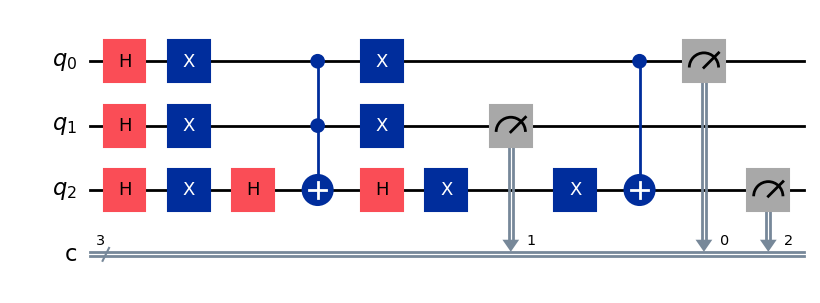

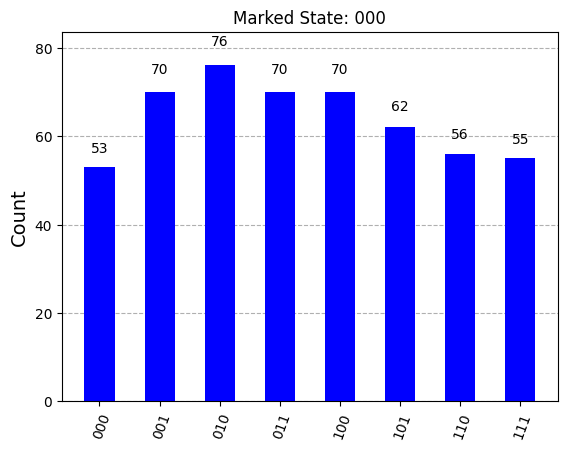

=== Circuit for Marked State 001 ===


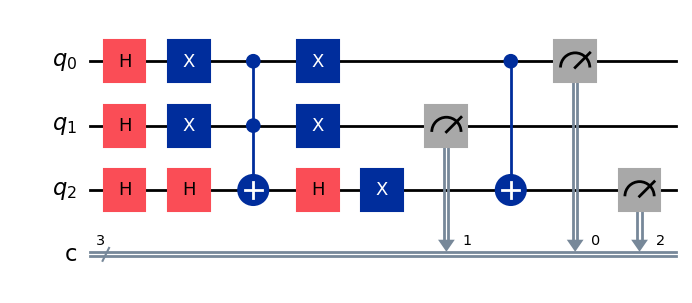

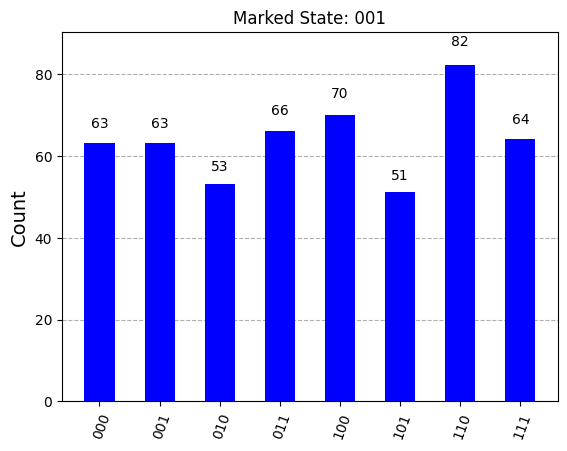

=== Circuit for Marked State 010 ===


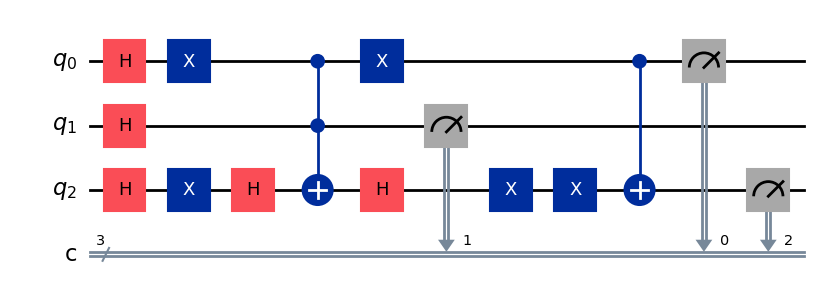

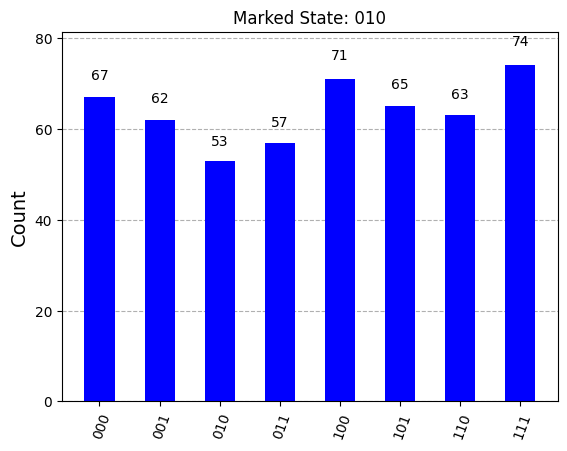

=== Circuit for Marked State 011 ===


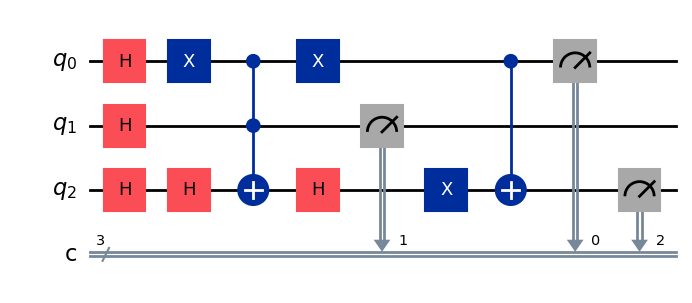

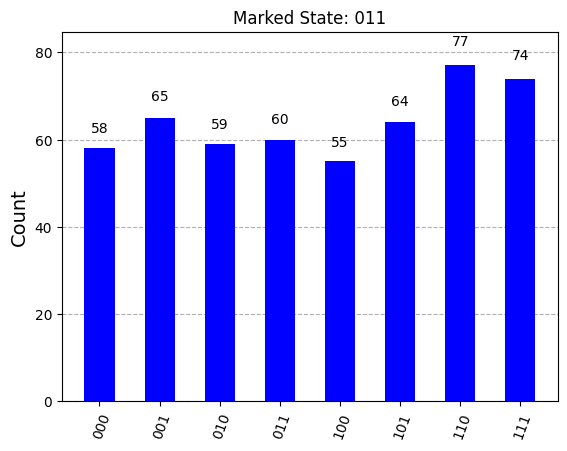

=== Circuit for Marked State 100 ===


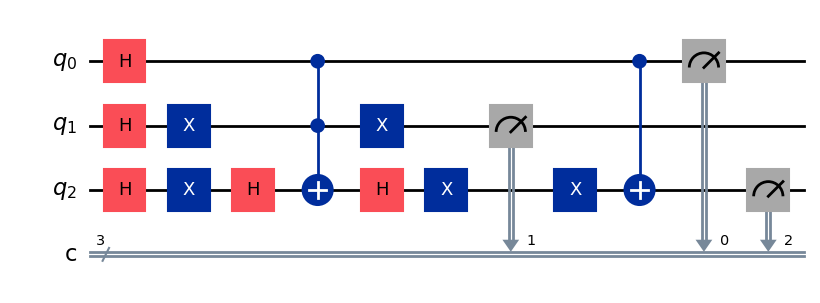

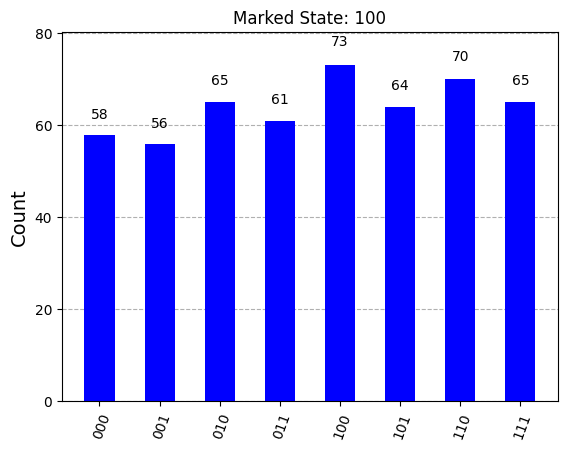

=== Circuit for Marked State 101 ===


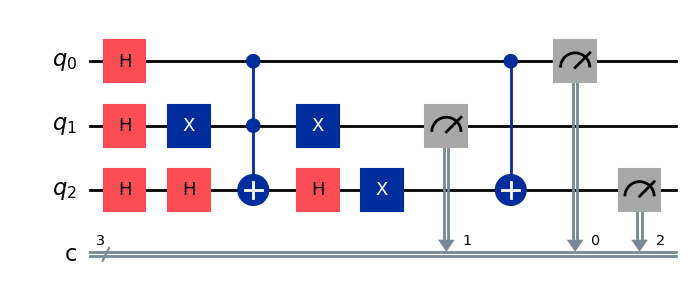

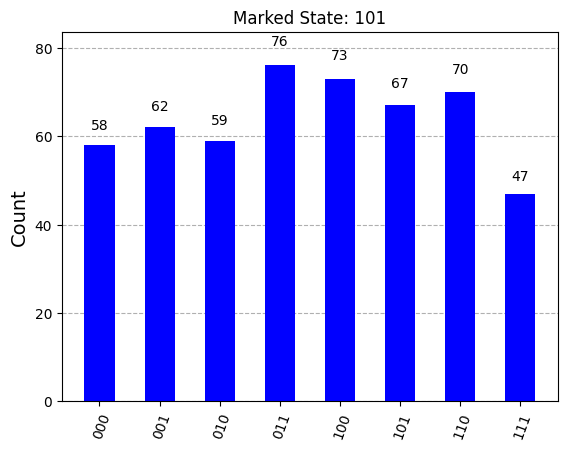

=== Circuit for Marked State 110 ===


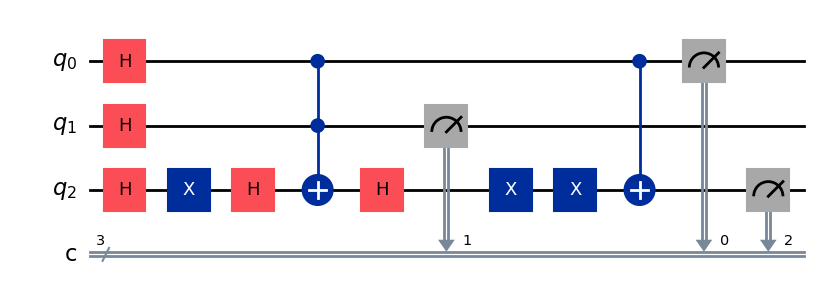

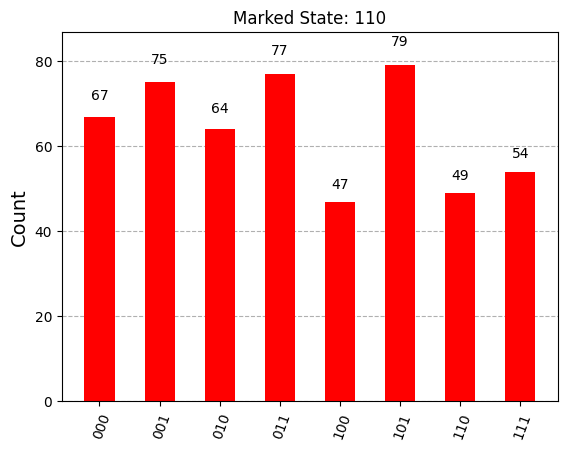

=== Circuit for Marked State 111 ===


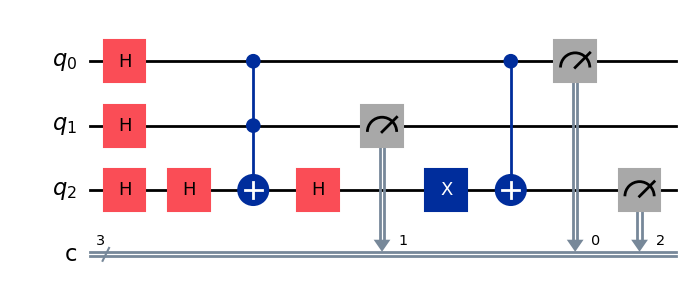

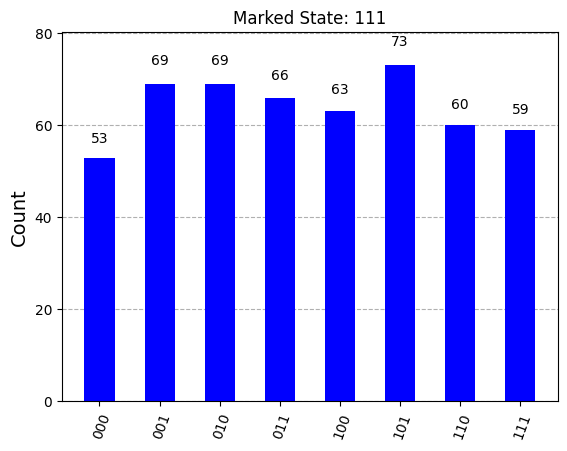

In [26]:
import matplotlib.pyplot as plt

for state in marked_states:
    # Build circuit for this state:
    new_oracle = generate_oracle_code(state)
    modified_phenotype = replace_oracle_block(phenotype_str, new_oracle)
    local_vars = {}
    exec(modified_phenotype, globals(), local_vars)
    qc = local_vars["qc"]
    
    # Transpile and execute:
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=512).result()
    counts = result.get_counts()

    # 1) Show the circuit
    print(f"=== Circuit for Marked State {state} ===")
    display(qc.draw('mpl'))  # Renders the circuit diagram inline
    
    # 2) Plot the histogram
    color_map = ['red' if key == state else 'blue' for key in counts.keys()]
    fig = display(plot_histogram(counts, color=color_map, title=f"Marked State: {state}"))
    
    # Explicitly show the plot:
    plt.show()

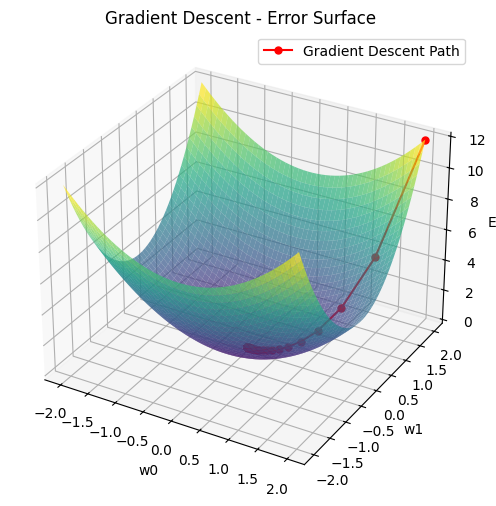

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the error function E(w0, w1) - Example Quadratic Function
def error_function(w0, w1):
    return w0**2 + 2*w1**2  # A simple convex function

# Compute gradient of E(w0, w1)
def gradient(w0, w1):
    dE_dw0 = 2 * w0
    dE_dw1 = 4 * w1
    return np.array([dE_dw0, dE_dw1])

# Perform gradient descent
def gradient_descent(learning_rate=0.1, iterations=50):
    w = np.array([2.0, 2.0])  # Initial weights (starting point)
    history = [w.copy()]

    for _ in range(iterations):
        grad = gradient(w[0], w[1])
        w -= learning_rate * grad  # Apply Delta Rule
        history.append(w.copy())

    return np.array(history)

# Generate meshgrid for the error surface
w0_vals = np.linspace(-2, 2, 50)
w1_vals = np.linspace(-2, 2, 50)
W0, W1 = np.meshgrid(w0_vals, w1_vals)
E_vals = error_function(W0, W1)

# Perform gradient descent and get weight updates
history = gradient_descent()

# Plot the 3D error surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W0, W1, E_vals, cmap="viridis", alpha=0.7)

# Plot the gradient descent path
history_E = error_function(history[:, 0], history[:, 1])
ax.plot(history[:, 0], history[:, 1], history_E, 'ro-', markersize=5, label="Gradient Descent Path")

# Labels and title
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_zlabel("E(w)")
ax.set_title("Gradient Descent - Error Surface")

plt.legend()
plt.show()